<a href="https://colab.research.google.com/github/dong-gi-jang/binfo/blob/main/Final/Final_Fig5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free 2
## LIN28A is a suppressor of ER-associated translation in embryonic stem cells
[위 논문](https://doi.org/10.1016/j.cell.2012.10.019)의 Fig.5A (GO enrichment analysis) 재현하기

In [47]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## installation

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

!conda install -y subread

## import dataset

Subread featurecounts이용한 gene별 read count 계산.

ignore multimapping.



  
```
# run subread featureCounts
!featureCounts -a gencode.gtf -o read-counts.txt *.bam 
```

In [ ]:
# 기존 week1 read-counts.txt 파일 가져와서 진행.
%cd /content/drive/MyDrive/binfo1-datapack1/
import pandas as pd
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

/content/drive/MyDrive/binfo1-datapack1


## read-counts matrix processing

In [ ]:
# featurecounts assign 결과 매트릭스에서, column별 total sum scaling.
# 계산된 clip_enrichment, rden_change : log 2 transformation.

import numpy as np

cnts['log2_clip_enrichment'] = np.log2(   ( cnts['CLIP-35L33G.bam']/cnts['CLIP-35L33G.bam'].sum() )   /   ( cnts['RNA-control.bam']/cnts['RNA-control.bam'].sum() )   )
cnts['log2_rden_change'] = np.log2(  
    (   ( cnts['RPF-siLin28a.bam']/cnts['RPF-siLin28a.bam'].sum() ) / ( cnts['RNA-siLin28a.bam']/cnts['RNA-siLin28a.bam'].sum() )   )
    /
    (   ( cnts['RPF-siLuc.bam']/cnts['RPF-siLuc.bam'].sum() ) / ( cnts['RNA-siLuc.bam']/cnts['RNA-siLuc.bam'].sum() )   )   
    )

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
### total sum scaling 없이 하려는 경우.
import numpy as np

cnts['log2_clip_enrichment'] = np.log2(   cnts['CLIP-35L33G.bam']   /    cnts['RNA-control.bam']   )
cnts['log2_rden_change'] = np.log2(  
    (   cnts['RPF-siLin28a.bam']/  cnts['RNA-siLin28a.bam']   )
    /
    (    cnts['RPF-siLuc.bam'] / cnts['RNA-siLuc.bam']   )   
    )

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Ensembl GeneId(index) 점 뒤쪽 제거 : gene level에서 분석.
import copy

cnts_rmdot = copy.deepcopy(cnts)
cnts_rmdot.index = cnts_rmdot.index.map(lambda p : p.split('.')[0])

In [ ]:
# cutoff 지정, low abundant 제거.

# We excluded transcripts with low read counts in RNA-seq (<30 raw reads)
rna_cutoff = 30

# exclude transcripts with low ribosome occupancy(<80 raw reads in siLuc)
ribo_cutoff = 80

rnabool = cnts_rmdot['RNA-siLuc.bam'] > rna_cutoff
lin28abool = cnts_rmdot['RNA-siLin28a.bam'] > rna_cutoff
clipbool = cnts_rmdot['RNA-control.bam'] > rna_cutoff

ribobool = cnts_rmdot['RPF-siLuc.bam'] > ribo_cutoff

cnts_cutoff = cnts_rmdot[ribobool & rnabool & lin28abool & clipbool]

In [ ]:
# log2 rden_change, clip_enrichment 컬럼에 nan값이나 -inf값 포함 여부 확인.
print('nan # : ',len(cnts_cutoff[cnts_cutoff['log2_clip_enrichment'].isnull() | cnts_cutoff['log2_rden_change'].isnull()]))
print('-inf # : ', len(cnts_cutoff[(cnts_cutoff['log2_clip_enrichment']==-np.inf) | (cnts_cutoff['log2_rden_change']==-np.inf) ]))

nan # :  0
-inf # :  2


In [ ]:
# -inf값 2개 확인. 제거된 df 이용
cnts_noinf = cnts_cutoff[cnts_cutoff['log2_clip_enrichment']!=-np.inf]

In [ ]:
# matrix에 포함된 gene 목록 리스트
raw_genelist= cnts_noinf.index.tolist()
# 중복된 gene 여부 확인
print(len(raw_genelist),len(set(raw_genelist)))

7958 7958


## Identifier mapping

In [ ]:
# EnsEMBL Gene ID를 gene symbol, uniprot accession으로 mapping 위해 설치
!pip install gseapy

In [ ]:
import gseapy as gp
bm = gp.parser.Biomart()

In [ ]:
# M.musculus dataset에 대해서 가져올 수 있는 attributes 목록 확인해보기
attributetable = bm.get_attributes('mmusculus_gene_ensembl')
attributetable

,Attribute,Description
0,ensembl_gene_id,Gene stable ID
1,ensembl_gene_id_version,Gene stable ID version
2,ensembl_transcript_id,Transcript stable ID
3,ensembl_transcript_id_version,Transcript stable ID version
4,ensembl_peptide_id,Protein stable ID
...,...,...
2875,cdna,cDNA sequences
2876,coding,Coding sequence
2877,peptide,Peptide
2878,upstream_flank,upstream_flank


In [ ]:
# GO term 관련 attribute 확인
attributetable[attributetable['Description'].str.contains('GO')]

,Attribute,Description
41,go_id,GO term accession
42,name_1006,GO term name
43,definition_1006,GO term definition
44,go_linkage_type,GO term evidence code
45,namespace_1003,GO domain
46,goslim_goa_accession,GOSlim GOA Accession(s)
47,goslim_goa_description,GOSlim GOA Description


In [ ]:
# GO id, GO domain, GO tern name 가져올 수 있음을 확인. 
# GO domain 가져오는 이유 : 논문에서는 GO:CC는 상위 텀만 manual하게 몇 개 선택하여 visualize한 것으로 보임.
# 따라서 GO:MF, GO:BP와는 따로 처리해야 될 것.
# GO term name 가져오는 이유 : 이후 figure에 말풍선 tagging해야 해서

# ID 매핑 진행 (2분 이상 소요)
mapped =  bm.query(dataset='mmusculus_gene_ensembl',attributes=['ensembl_gene_id','external_gene_name','go_id','namespace_1003','name_1006'],filters={'ensembl_gene_id':raw_genelist})
mapped.shape

(484126, 5)

In [ ]:
# 생각보다 행의 값 전체가 중복되는 행들 많음. 중복 행 제거.
mapped_nodup = mapped.drop_duplicates(['ensembl_gene_id','external_gene_name','go_id','namespace_1003','name_1006'])
mapped_nodup.shape

(163383, 5)

In [ ]:
# 넣어준 genelist가 전부 mapping되었는지 여부 개수로 확인.
print(len(raw_genelist),len(set(raw_genelist)),len(set(mapped_nodup['ensembl_gene_id'].tolist()))) 

7958 7958 7958


In [ ]:
# GO domain 별 table 분리
GOCC = mapped_nodup[mapped_nodup['namespace_1003']=='cellular_component']
GOMF = mapped_nodup[mapped_nodup['namespace_1003']=='molecular_function']
GOBP = mapped_nodup[mapped_nodup['namespace_1003']=='biological_process']
print('GOCC # :', len(GOCC), '\nGOMF # :', len(GOMF), '\nGOBP # :', len(GOBP))
# mapping 결과 매트릭스에는 NaN값도 꽤 많음.

GOCC # : 48457 
GOMF # : 37978 
GOBP # : 70066


In [ ]:
# 각 GO term별 match된 input dataset 내 gene count 세서 딕셔너리로 만듦.

count={}
lists = mapped_nodup['go_id'].tolist()
for i in lists:
    try: count[i] += 1
    except: count[i]=1

In [ ]:
# 내림차순으로 count 딕셔너리 정렬
sorted_count = sorted(count.items(), key = lambda item: item[1],reverse=True)

-  cnts_noinf : ensembl, logC, logR
- mapped_nodup : ensembl, GO ID
- sorted_count : GO ID, count

## Statistical test

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mann-Whitney U test
# 각 GO term member vs member 제외 전체 gene.
# Go term member들의 log2 Clip enrichment, Rden change 평균도 구함.
from tqdm import tqdm
from scipy import stats

# test 결과 받을 새 df 만듦.
stat_result = pd.DataFrame(columns=['GO-term','count','CLIP_mean','Rden_mean','Clip_p-value','Rden_p-value'])
for i,j in tqdm(sorted_count[1:]): # count 내림차순에서 index 0은 nan이라 제외.
  # 각 go term, others 내 gene들의 rden_change, clip_enrichment 값 가져오기.
  temp_genelist = mapped_nodup[mapped_nodup['go_id']==i]['ensembl_gene_id'].tolist()
  gomember = cnts_noinf[cnts_noinf.index.isin(temp_genelist)]
  others =  cnts_noinf[~cnts_noinf.index.isin(temp_genelist)]
  # go term member들의 rden_change, clip_enrich 평균 구하기.
  logR_avg = np.mean(gomember['log2_rden_change'])
  logC_avg = np.mean(gomember['log2_clip_enrichment'])
  # Mann-Whitney 결과 p-value.
  Clip_pvalue = list(stats.mannwhitneyu(gomember['log2_clip_enrichment'],others['log2_clip_enrichment']))[1]
  Rden_pvalue = list(stats.mannwhitneyu(gomember['log2_rden_change'],others['log2_rden_change']))[1]
  # append to df
  row = [i,j,logC_avg, logR_avg, Clip_pvalue, Rden_pvalue ]
  stat_result = stat_result.append(pd.Series(row, index=stat_result.columns), ignore_index=True)

100%|██████████| 14495/14495 [06:01<00:00, 40.09it/s]


In [ ]:
# R package 이용, FDR 계산.
# https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

statsr = importr('stats')

p_adjust_clip = statsr.p_adjust(FloatVector(stat_result['Clip_p-value']), method = 'BH')
p_adjust_rpf = statsr.p_adjust(FloatVector(stat_result['Rden_p-value']), method = 'BH')

In [ ]:
stat_result['Clip_FDR']=list(p_adjust_clip)
stat_result['Rden_FDR']=list(p_adjust_rpf)

In [ ]:
# 중간 저장.
cnts_noinf.to_csv('./cnts_noinf.csv')
mapped_nodup.to_csv('./mapped_nodup.csv',index=False)
stat_result.to_csv('./stat_result.csv',index=False)

In [ ]:
# 중간 저장 불러오기.
cnts_noinf = pd.read_csv('./cnts_noinf.csv',index_col=0)
mapped_nodup = pd.read_csv('./mapped_nodup.csv')
stat_result = pd.read_csv('./stat_result.csv')

In [ ]:
# nucleosome, nucleosome assembly term 확인.
# FDR cutoff에서 잘림.
# clip enrich되지도 않는 것 같다. 이유?
stat_result[(stat_result['GO-term']=='GO:0000786') | (stat_result['GO-term']=='GO:0006334')]

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_FDR,Rden_FDR
510,GO:0000786,40,-0.676817,-0.450360,0.286739,0.020536,0.422858,0.160298
562,GO:0006334,37,-0.555451,-0.516924,0.466404,0.007203,0.488612,0.096309


In [ ]:
# FDR 0.05 cutoff
# clip_enrich와 rden_change 둘 다에 대해 cutoff 적용.
### stat_result_fdr = stat_result[stat_result['Clip_FDR']<0.05 ]
stat_result_fdr = stat_result[(stat_result['Clip_FDR']<0.05) &(stat_result['Rden_FDR']<0.05)]
stat_result_fdr.shape

(135, 8)

In [ ]:
# 테스트 결과 table에 GO domain 및 term name mapping
godomain_term = mapped_nodup.drop_duplicates(['go_id'])
finaltable = stat_result_fdr.join(godomain_term.set_index('go_id')[['namespace_1003','name_1006']], on='GO-term')
finaltable.head()

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_FDR,Rden_FDR,namespace_1003,name_1006
0,GO:0005737,3579,-0.755151,-0.412859,6.724366e-25,5.514366e-93,1.624495e-21,1.332179e-89,cellular_component,cytoplasm
1,GO:0005634,3442,-0.727147,-0.446982,3.519651e-14,8.380815e-129,3.188584e-11,4.049331e-125,cellular_component,nucleus
3,GO:0016020,2707,-0.227613,0.036669,4.493757e-81,1.926556e-236,3.256850e-77,1.396271e-232,cellular_component,membrane
4,GO:0005829,2336,-0.784151,-0.437004,1.799103e-17,3.624343e-63,2.370727e-14,5.837205e-60,cellular_component,cytosol
5,GO:0005654,2098,-0.767952,-0.473036,6.603918e-13,2.181873e-81,4.786189e-10,4.518035e-78,cellular_component,nucleoplasm


## Visualization

In [ ]:
# membrane, integral component of membrane 등 크게 의미 없는 term들 manually 제외 필요.
# ER과 무관한 organelle 내 suborganellular local 등 하위 term도 제외.
# 아예 bubble도 그려지지 않도록.
excllist = ['membrane','cytosol','nucleoplasm','integral component of membrane','integral component of plasma membrane','extracellular space','identical protein binding','nucleotide binding','DNA binding','RNA binding','cytoplasmic vesicle']
pltinput = finaltable[~finaltable['name_1006'].isin(excllist)]

In [ ]:
# 진한, 중요한 bubble이 앞에 오도록 문제 해결 필요 : pltinput 색 진하기(clip fdr) 역순으로 정렬 후 scatter
pltinput = pltinput.sort_values('Clip_FDR',ascending=False)

In [ ]:
# GO term 말풍선 tagging할 때는, bubble 크기 (count) 역순으로 정렬 후 순서대로 붙혀주기.
pltinput_sortcount = pltinput.sort_values('count',ascending=False).set_index('GO-term')

In [ ]:
import copy
pltinput_practice = copy.deepcopy(pltinput)

In [ ]:
pltinput_practice['countrank'] = pltinput_practice['count'].rank(method='dense',ascending=False)
pltinput_practice['clipfdrrank'] = pltinput_practice['Clip_FDR'].rank(method='dense',ascending=True)
pltinput_practice['ranks'] = pltinput_practice['countrank'] + pltinput_practice['clipfdrrank']

In [ ]:
pltinput_practice = pltinput_practice.sort_values('ranks')

In [ ]:
# 내 분석에서, FDR cutoff 된 결과에서는 nucleosome이나 nucleosome assembly 관련 term 나오지 않음을 확인.
pltinput_sortcount[pltinput_sortcount['name_1006']=='nucleosome assembly']

,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_FDR,Rden_FDR,namespace_1003,name_1006
GO-term,,,,,,,,,


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


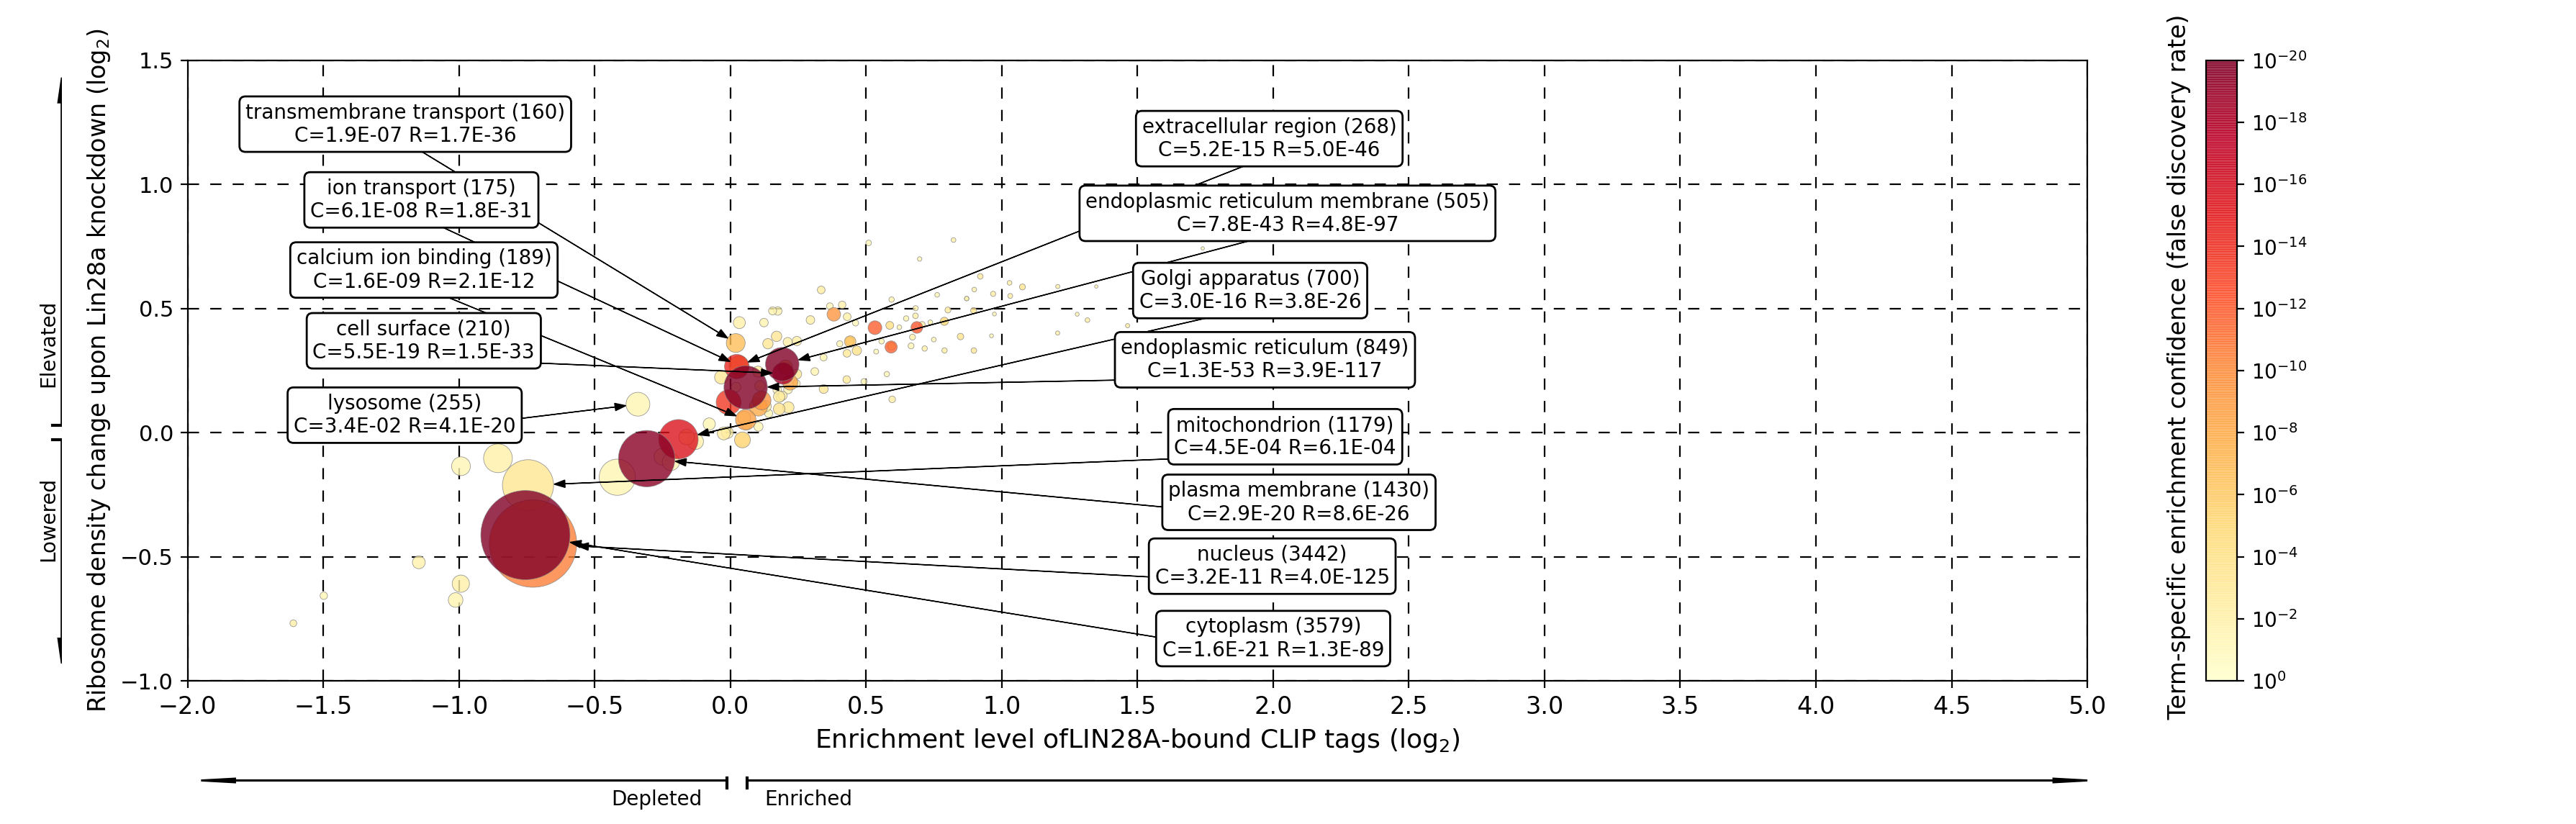

In [ ]:
# Visualization
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
np.random.seed(2)

# figure 내 balloon 관련 설정
box1 = {'boxstyle': 'round',
        'ec': 'black',
        'fc':'white'}

# figure, grid 관련 설정. 3개 subplot 합쳐서 하나로 보이게 제작.
plt.figure(figsize=(18,6), dpi=200)
gs = gridspec.GridSpec(nrows=2,ncols=2,width_ratios=[1,50],height_ratios=[25,1])


# main bubbleplot 설정
ax1 = plt.subplot(gs[1])
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)',fontsize=13)
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)',fontsize=12)
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5),fontsize=12)
plt.yticks(np.arange(-1, 1.51, step=0.5),fontsize=11)
plt.grid(True, color='black', linestyle='--',dashes=(7,7),linewidth=0.8)
plt.scatter(pltinput['CLIP_mean'],  pltinput['Rden_mean'],  s=(pltinput['count']/1.8).tolist(), # 크기 너무 크면 가리므로, 약간 줄여서 진행.
            c=pltinput['Clip_FDR'].tolist(), norm=colors.LogNorm(vmin=10**-20, vmax=1),alpha=0.8, cmap='YlOrRd_r',zorder=2,edgecolors='grey',linewidth=0.3) # 우선은 alpha값 설정하여 보기.


# balloon 위치 지정, text 지정, arrow
## 임의의 balloon 위치 지정
xval = 2
yval = -0.9
## 임의의 값으로 scaling하여, radius에 비례할 값 도출.
pltinput_sortcount['scaled_radius'] = (( (pltinput_sortcount['count'])**0.5 ) * 0.0028).tolist()
## 몇개만 일단 테스트
excludelist = ['cytoskeleton','intracellular membrane-bounded organelle','mitochondrial inner membrane','Golgi membrane']
repeatcount = 0
for i in pltinput_sortcount.index[:16]: 
  if repeatcount ==8:
    xval = -1.2
    yval = 0
  textname = pltinput_sortcount.loc[i,'name_1006']
  if textname in excludelist:
    continue
  cval = pltinput_sortcount.loc[i,'Clip_FDR']
  rval = pltinput_sortcount.loc[i,'Rden_FDR']
  count = pltinput_sortcount.loc[i,'count']
  scaled_radius = pltinput_sortcount.loc[i,'scaled_radius']
  # arrow가 가르켜야 할 bubble의 중심위치 지정
  bubx = pltinput_sortcount.loc[i,'CLIP_mean']
  buby = pltinput_sortcount.loc[i,'Rden_mean']
  # bubble의 원주에 화살표가 닿게 하기 위해, arrow 길이 radius 정도만큼 짧게 해주는 게 목표.
  len_to_bubcenter = ((bubx-xval)**2 + (buby-yval)**2)**(1/2)
  len_to_bubcircum = len_to_bubcenter - scaled_radius
  len_ratio = (len_to_bubcircum/len_to_bubcenter)
  dxtocircum = abs(xval-bubx)*len_ratio
  dytocircum = abs(yval-buby)*len_ratio
  if xval > bubx :
    dxtocircum = -dxtocircum
  if yval > buby :
    dytocircum = -dytocircum
  plt.arrow(xval, yval, dxtocircum, dytocircum, zorder =3, head_width=0.03,lw=0.5,color='black',head_length=0.04,length_includes_head=True)
  plt.text(xval, yval, f'{textname} ({count})\nC={cval:.1E} R={rval:.1E}', bbox=box1,ha='center',zorder=4)
  yval +=(0.3+np.random.normal(0,0.02))
  xval += np.random.normal(0,0.06)
  repeatcount+=1


# 오른쪽 colorbar 관련 설정
b = plt.colorbar()
b.ax.set_ylabel(' Term-specific enrichment confidence (false discovery rate)', rotation=90, labelpad = -70,fontsize=12)
b.set_ticks([10**-0, 10**-2,10**-4,10**-6,10**-8,10**-10,10**-12,10**-14,10**-16,10**-18,10**-20])
b.ax.invert_yaxis()


# 왼쪽 Ribosome density arrow 설정
ax2 = plt.subplot(gs[0],sharey=ax1)
plt.xlim(0,0)
plt.axis('off')
plt.arrow(0.05,0.03,0,1.4,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.arrow(0.05,-0.03,0,-0.9,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.text(0,0.2,'Elevated',rotation=90)
plt.text(0,-0.5,'Lowered',rotation=90)
plt.plot([0.03, 0.08], [0.03, 0.03],color="black")
plt.plot([0.03, 0.08], [-0.03, -0.03],color="black")


# 아래 Clip enrichment arrow 설정
ax3 = plt.subplot(gs[3],sharex=ax1)
plt.ylim(0,0)
plt.axis('off')
plt.arrow(-0.35,0.03,3.95,0,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.arrow(-0.41,0.03,-1.55,0,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.text(-0.3,-0.07,'Enriched')
plt.text(-0.75,-0.07,'Depleted')
plt.plot([-0.35, -0.35], [0.04, 0],color="black")
plt.plot([-0.41, -0.41], [0.04, 0],color="black")


# plotting
plt.tight_layout()
plt.show()
None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


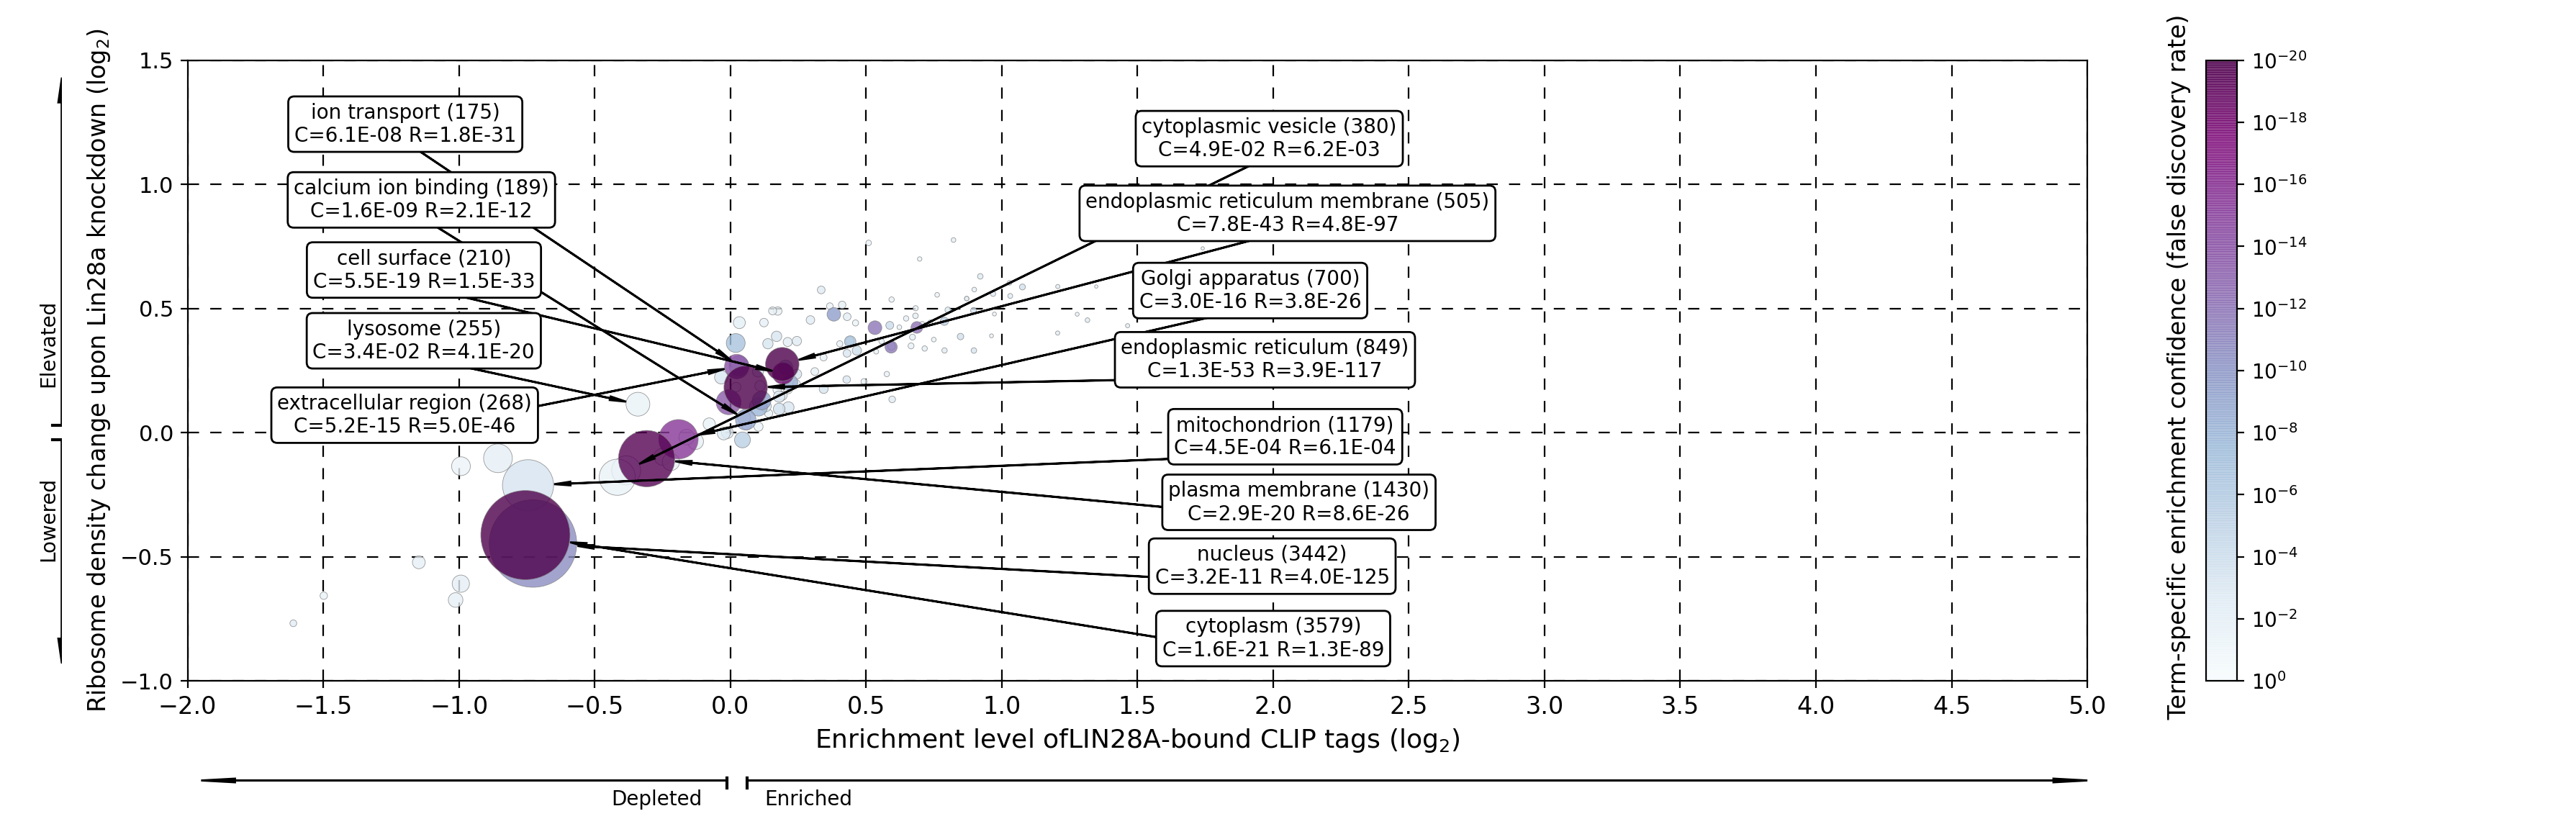

In [ ]:
## color 다른 것 이용해서. 노란 점 잘 안보이니까.
# Visualization

from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
np.random.seed(2)

# figure 내 balloon 관련 설정
box1 = {'boxstyle': 'round',
        'ec': 'black',
        'fc':'white'}

# figure, grid 관련 설정. 3개 subplot 합쳐서 하나로 보이게 제작.
plt.figure(figsize=(18,6), dpi=200)
gs = gridspec.GridSpec(nrows=2,ncols=2,width_ratios=[1,50],height_ratios=[25,1])


# main bubbleplot 설정
ax1 = plt.subplot(gs[1])
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)',fontsize=13)
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)',fontsize=12)
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5),fontsize=12)
plt.yticks(np.arange(-1, 1.51, step=0.5),fontsize=11)
plt.grid(True, color='black', linestyle='--',dashes=(7,7),linewidth=0.8)
plt.scatter(pltinput['CLIP_mean'],  pltinput['Rden_mean'],  s=(pltinput['count']/1.8).tolist(), # 크기 너무 크면 가리므로, 약간 줄여서 진행.
            c=pltinput['Clip_FDR'].tolist(), norm=colors.LogNorm(vmin=10**-20, vmax=1),alpha=0.8, cmap='BuPu_r',zorder=2,edgecolors='grey',linewidth=0.3) # 우선은 alpha값 설정하여 보기.


# balloon 위치 지정, text 지정, arrow
## 임의의 balloon 위치 지정
xval = 2
yval = -0.9
## 임의의 값으로 scaling하여, radius에 비례할 값 도출.
pltinput_sortcount['scaled_radius'] = (( (pltinput_sortcount['count'])**0.5 ) * 0.0028).tolist()
## 몇개만 일단 테스트
excludelist = ['cytoskeleton','intracellular membrane-bounded organelle','RNA binding','mitochondrial inner membrane','Golgi membrane']
repeatcount = 0
for i in pltinput_sortcount.index[:16]: 
  if repeatcount ==8:
    xval = -1.2
    yval = 0
  textname = pltinput_sortcount.loc[i,'name_1006']
  if textname in excludelist:
    continue
  cval = pltinput_sortcount.loc[i,'Clip_FDR']
  rval = pltinput_sortcount.loc[i,'Rden_FDR']
  count = pltinput_sortcount.loc[i,'count']
  scaled_radius = pltinput_sortcount.loc[i,'scaled_radius']
  # arrow가 가르켜야 할 bubble의 중심위치 지정
  bubx = pltinput_sortcount.loc[i,'CLIP_mean']
  buby = pltinput_sortcount.loc[i,'Rden_mean']
  # bubble의 원주에 화살표가 닿게 하기 위해, arrow 길이 radius 정도만큼 짧게 해주는 게 목표.
  len_to_bubcenter = ((bubx-xval)**2 + (buby-yval)**2)**(1/2)
  len_to_bubcircum = len_to_bubcenter - scaled_radius
  len_ratio = (len_to_bubcircum/len_to_bubcenter)
  dxtocircum = abs(xval-bubx)*len_ratio
  dytocircum = abs(yval-buby)*len_ratio
  if xval > bubx :
    dxtocircum = -dxtocircum
  if yval > buby :
    dytocircum = -dytocircum
  plt.arrow(xval, yval, dxtocircum, dytocircum, zorder =3, head_width=0.015,lw=1,color='black',head_length=0.06,length_includes_head=True)
  plt.text(xval, yval, f'{textname} ({count})\nC={cval:.1E} R={rval:.1E}', bbox=box1,ha='center',zorder=4)
  yval +=(0.3+np.random.normal(0,0.02))
  xval += np.random.normal(0,0.06)
  repeatcount+=1


# 오른쪽 colorbar 관련 설정
b = plt.colorbar()
b.ax.set_ylabel(' Term-specific enrichment confidence (false discovery rate)', rotation=90, labelpad = -70,fontsize=12)
b.set_ticks([10**-0, 10**-2,10**-4,10**-6,10**-8,10**-10,10**-12,10**-14,10**-16,10**-18,10**-20])
b.ax.invert_yaxis()


# 왼쪽 Ribosome density arrow 설정
ax2 = plt.subplot(gs[0],sharey=ax1)
plt.xlim(0,0)
plt.axis('off')
plt.arrow(0.05,0.03,0,1.4,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.arrow(0.05,-0.03,0,-0.9,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.text(0,0.2,'Elevated',rotation=90)
plt.text(0,-0.5,'Lowered',rotation=90)
plt.plot([0.03, 0.08], [0.03, 0.03],color="black")
plt.plot([0.03, 0.08], [-0.03, -0.03],color="black")


# 아래 Clip enrichment arrow 설정
ax3 = plt.subplot(gs[3],sharex=ax1)
plt.ylim(0,0)
plt.axis('off')
plt.arrow(-0.35,0.03,3.95,0,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.arrow(-0.41,0.03,-1.55,0,head_width=0.015,lw=1,color='black',head_length=0.1,length_includes_head=True)
plt.text(-0.3,-0.07,'Enriched')
plt.text(-0.75,-0.07,'Depleted')
plt.plot([-0.35, -0.35], [0.04, 0],color="black")
plt.plot([-0.41, -0.41], [0.04, 0],color="black")


# plotting
plt.tight_layout()
plt.show()
None

In [ ]:
# 첫 피규어 참고하여, arrow 서로 교차되는 것 제거하기 위해
# 임의의 순서대로 Gene name 넣은 list 만들기.
balloonorderlist = ['nucleus','cytoplasm','mitochondrion','']